This Notebook is meant to present Geospatial information for Egypt. 

In [24]:
import pandas as pd
from pandas import DataFrame as df

In [25]:
#Creating lists and latitude and longitude for processing
#creating the lists for openmateo
initial_long = 25 #Initial longitude
initial_lat_x= 22
initial_lat= 22  #Initial latitude

long_i=0
lat_i=0
step=0.75

Long_list=[]; #Long_list.append(initial_long)  # Initialize list for longitudes
Lat_list=[] ; #Lat_list.append(initial_lat)  # Initialize list for latitudes



while initial_long <= 35.01+step:  #max Longitude
 # Reset latitude for each new longitude
    while  initial_lat<=32.21+step: #max Latitude



        Lat_list.append(initial_lat)
        Long_list.append(initial_long)
        long_i+=1
        initial_lat+=step

    initial_lat = 22  # Reset latitude for the next longitude
    initial_long+=step       
    lat_i+=1


print(len(Lat_list))
print(len(Long_list))

print("latitude" ,Lat_list)
print(Long_list)

#adding a couple of points manually

manual_points_lang = [35.5, 35.5,35.5, 35.5,37, 24.5, 24.8]
manual_points_lat = [22,23, 24, 25,22, 30.2, 31.5]
for k in manual_points_lang:
        Long_list.append(k)
for k in manual_points_lat:
        Lat_list.append(k)



225
225
latitude [22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25.75, 26.5, 27.25, 28.0, 28.75, 29.5, 30.25, 31.0, 31.75, 32.5, 22, 22.75, 23.5, 24.25, 25.0, 25

In [26]:
#Processing Data with OPen Meteo
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"


avg_temps = []  # List to store average temperatures for each date
temps=[]
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
for i in range(len(Lat_list)):
        params = {
            "latitude": Lat_list,   # Example: Egypt
            "longitude": Long_list,
            # Add more variables as needed, e.g., "temperature_2m_max", "precipitation_sum", etc.
            # Ensure the variable names match those in the Open-Meteo API documentation
            "daily": "shortwave_radiation_sum",
            "start_date": "2020-01-01",
            "end_date":"2024-12-31",
            "timezone": "Africa/Cairo"
        }
        responses = openmeteo.weather_api(url, params=params)
        temp=responses[i].Daily().Variables(0).ValuesAsNumpy()
        temps.append(sum(temp)/len(temp))  # Calculate average temperature for the year





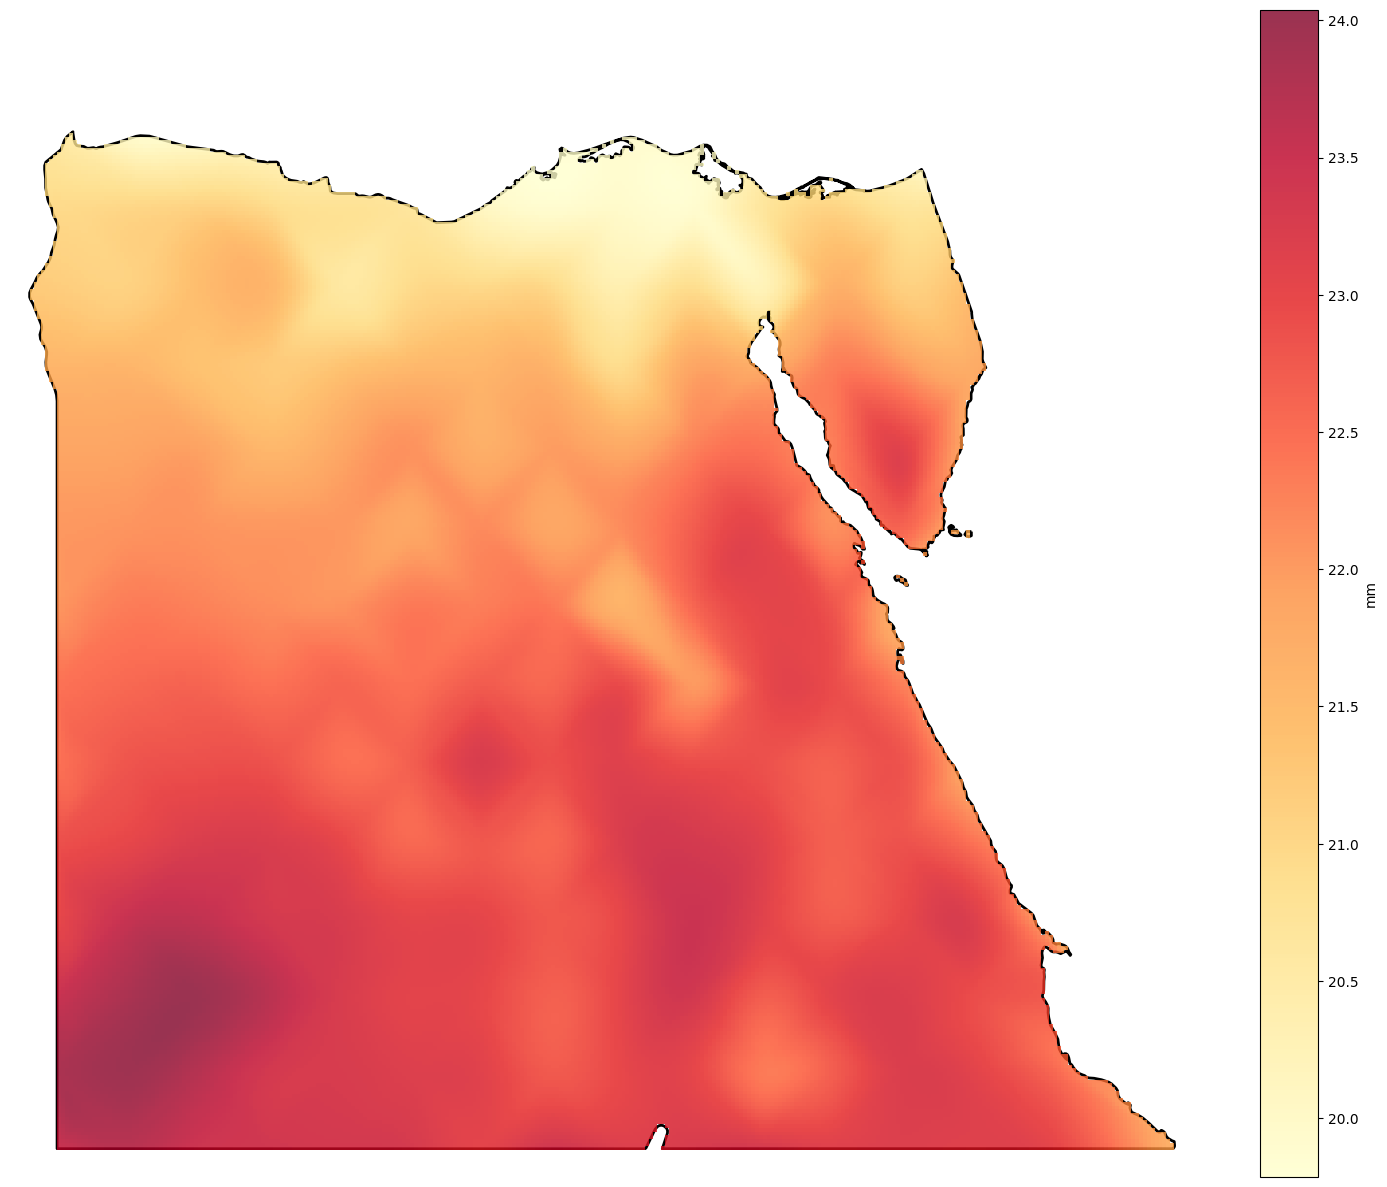

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
import geopandas as gpd
import numpy.ma as ma
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    dfResults,
    geometry=gpd.points_from_xy(dfResults.Longitude, dfResults.Latitude),
    crs="EPSG:4326"
)



# Reproject geometries
gdf_3857 = gdf.to_crs(epsg=3857)
egypt_3857 = egypt.to_crs(epsg=3857)


# Define a coarse grid covering all points (including those outside Egypt)
x = np.linspace(gdf_3857.geometry.x.min(), gdf_3857.geometry.x.max(), 300)
y = np.linspace(gdf_3857.geometry.y.min(), gdf_3857.geometry.y.max(), 300)
X, Y = np.meshgrid(x, y)

# Interpolate using ALL points (including those outside Egypt)
Z = griddata(
    (gdf_3857.geometry.x, gdf_3857.geometry.y),
    dfResults['Average Temperature'],
    (X, Y),
    method='cubic'  # Use 'nearest' to avoid NaNs outside Egypt
)

# Create a mask where True = inside Egypt, False = outside
mask = np.zeros_like(Z, dtype=bool)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        point = Point(X[i,j], Y[i,j])
        mask[i,j] = egypt_3857.geometry.contains(point).any()

# Apply the mask to hide values outside Egypt
Z_masked = ma.masked_where(~mask, Z)

# Plot
fig, ax = plt.subplots(figsize=(15, 12))

# Plot Egypt boundaries (transparent fill, black border)
egypt_3857.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Plot the interpolated values (only where mask=True)
img = ax.pcolormesh(X, Y, Z_masked, cmap='YlOrRd', shading='auto', alpha=0.8)

# Optional: Plot original points (inside and outside Egypt)
#gdf_3857.plot(ax=ax, color='black', markersize=5, alpha=0.4)



# Add colorbar
cbar = fig.colorbar(img, ax=ax)
cbar.set_label('mm')

# Add basemap
#ctx.add_basemap(ax, source=ctx.providers.CartoDB.PositronNoLabels)

ax.set_title('  ', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()